In [1]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON
from datetime import datetime, timedelta
import isodate #parse
import os
import numpy as np
import csv

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [2]:
api_key = 'your_api_key'

In [3]:
channel_id='your_channel_id'

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_id)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        # Check if the channel has any subscriber milestone
        if 'bulletin' in item['contentDetails']:
            milestone = item['contentDetails']['bulletin']['resource']
            if milestone['kind'] == 'youtube#subscription':
                data['milestoneDate'] = milestone['publishedAt']
                data['milestoneSubscribers'] = milestone['metadata']['subscriberCount']
                
        all_data.append(data)
        
    return(pd.DataFrame(all_data))

In [6]:
request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=','.join(channel_id)
)
response = request.execute()
# JSON(response)

def get_channel_stats(response):
    stats_df = pd.read_csv('/Users/gulecs/Desktop/youtube api/media_stats/media_stats.csv')
    channel_stats = pd.DataFrame(data=stats_df[stats_df["channelName"]=="your_channel_name"])

    if "items" not in response.keys():
        return channel_stats
    else:
        channel_stats = get_channel_stats(youtube, channel_id)
        return channel_stats


In [7]:
channel_stats = get_channel_stats(response)
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,A Haber,648000,355928460,34180,UUKQhfw-lzz0uKnE1fY1PsAA


In [8]:
playlist_id = "UUKQhfw-lzz0uKnE1fY1PsAA"

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet, contentDetails",
            playlistId=playlist_id,
            maxResults = 50,
            pageToken = next_page_token)
   
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids

In [9]:
# Get Video IDs
video_ids=get_video_ids(youtube, playlist_id)

In [10]:
len(video_ids)

19996

In [11]:
def get_video_details(youtube, video_ids):

    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet, contentDetails, statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info={}
            video_info['video_id']=video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v]=None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [12]:
# Get video details 
df = get_video_details(youtube, video_ids)

## Data pre-processing

In [13]:
video_df = df.copy()
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19996 entries, 0 to 19995
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        19996 non-null  object
 1   channelTitle    19996 non-null  object
 2   title           19996 non-null  object
 3   description     19996 non-null  object
 4   tags            19996 non-null  object
 5   publishedAt     19996 non-null  object
 6   viewCount       19996 non-null  object
 7   likeCount       19996 non-null  object
 8   favouriteCount  0 non-null      object
 9   commentCount    19996 non-null  object
 10  duration        19996 non-null  object
 11  definition      19996 non-null  object
 12  caption         19996 non-null  object
dtypes: object(13)
memory usage: 2.0+ MB


In [14]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

# Create Month & Year columns
video_df['Month'] = pd.to_datetime(video_df["publishedAt"]).dt.strftime('%b')
video_df['Year'] = pd.to_datetime(video_df['publishedAt']).dt.strftime('%b')
video_df['Year'] = video_df['publishedAt'].dt.year

video_df["durationMins"] = (video_df["durationSecs"]/60).round(2).astype(float)
video_df["durationHours"] = (video_df["durationMins"]/60).round(2).astype(float)

# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [15]:
# Convert invalid values to NaN
video_df = video_df.replace({'viewCount': {'None': np.nan}, 
                              'likeCount': {'None': np.nan}, 
                              'commentCount': {'None': np.nan}})

# Drop rows with NaN values
video_df.dropna(subset=['viewCount', 'likeCount', 'commentCount'], inplace=True)

# Convert columns to int type
video_df = video_df.astype({"viewCount": int, "likeCount": int, "commentCount": int})

In [16]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19996 entries, 0 to 19995
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype                  
---  ------            --------------  -----                  
 0   video_id          19996 non-null  object                 
 1   channelTitle      19996 non-null  object                 
 2   title             19996 non-null  object                 
 3   description       19996 non-null  object                 
 4   tags              19996 non-null  object                 
 5   publishedAt       19996 non-null  datetime64[ns, tzutc()]
 6   viewCount         19996 non-null  int64                  
 7   likeCount         19996 non-null  int64                  
 8   favouriteCount    0 non-null      object                 
 9   commentCount      19996 non-null  int64                  
 10  duration          19996 non-null  object                 
 11  definition        19996 non-null  object                 
 12  capt

In [17]:
video_df.head(2)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,Month,Year,durationMins,durationHours,tagCount
0,AQlHttfcbUA,A Haber,Başkan Erdoğan 11 Nisan'da ne açıklayacak? Kon...,A Haber’de yayınlanan ve yazar Melih Altınok’u...,"[a haber, a haber tv, haber]",2023-03-27 22:30:01+00:00,177,10,None,0,PT14M41S,hd,false,Monday,881.0,Mar,2023,14.68,0.24,3
1,ouSCO25i6rU,A Haber,İnce'ye imza veren başörtülü kadınlar neden he...,A Haber’de yayınlanan ve yazar Melih Altınok’u...,"[a haber, a haber tv, haber]",2023-03-27 22:00:23+00:00,364,22,None,0,PT18M15S,hd,false,Monday,1095.0,Mar,2023,18.25,0.30,3


In [24]:
column_names = video_df.columns.values.tolist()
columns_removed = ["favouriteCount","caption","duration","definition","video_id","tags", "description","tagCount"]

# video_df = video_df.drop(["favouriteCount","caption","definition","video_id","duration"], axis=1, inplace = True)

# create new list using list comprehension
column_names = [i for i in column_names if i not in columns_removed]

print(column_names)

['channelTitle', 'title', 'publishedAt', 'viewCount', 'likeCount', 'commentCount', 'pushblishDayName', 'durationSecs', 'Month', 'Year', 'durationMins', 'durationHours']


In [25]:
file_name = video_df["channelTitle"].unique().tolist()
joined = ('_or_').join(file_name).replace(' ', '_').lower()

# Create directory
dirName = f"/Users/gulecs/Desktop/youtube api/media_stats/{joined}"

# Create target Directory if don't exist
if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists")

try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  /Users/gulecs/Desktop/youtube api/media_stats/a_haber  already exists
Directory  /Users/gulecs/Desktop/youtube api/media_stats/a_haber  already exists


In [28]:
# video_df["title"] = video_df["title"].str.replace("#shorts","")

path = f"/Users/gulecs/Desktop/youtube api/media_stats/{joined}/stats_{joined}.csv"
video_df.to_csv(path, index=False, columns=column_names)

In [29]:
video_df_before =video_df[video_df["publishedAt"]< "2023-02-06"]

path2= f"/Users/gulecs/Desktop/youtube api/media_stats/{joined}/{joined}_b4.csv"
video_df_before.to_csv(path2, index=False, columns=column_names)

In [30]:
video_df_after =video_df[video_df["publishedAt"]>= "2023-02-06"]

path3= f"/Users/gulecs/Desktop/youtube api/media_stats/{joined}/{joined}_aft.csv"
video_df_after.to_csv(path3, index=False, columns=column_names)

## Feature Engineering

### Ratios

In [31]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,A Haber,648000,355928460,34180,UUKQhfw-lzz0uKnE1fY1PsAA


In [32]:
# Video subscribers/video ratio
channel_stats["subscribers_per_video"] = round((channel_stats["subscribers"])/(channel_stats["totalVideos"]),0)

# Video view/video ratio
channel_stats["view_per_video"] = round((channel_stats["views"])/channel_stats["totalVideos"],0)

In [34]:
today = datetime.now()
current_month = int(today.strftime("%m"))
print("Current Month with Decimal Number :", current_month);

Current Month with Decimal Number : 3


#### Total - Monthly Video Uploads after

In [35]:
video_after_per_month = video_df_after.groupby('Month', as_index =False).size()
sort_order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',]
video_after_per_month.index = pd.CategoricalIndex(video_after_per_month['Month'], categories = sort_order, ordered= True)

video_after_per_month.reset_index(drop=True, inplace=True)
video_after_per_month = video_after_per_month.rename(columns={'size': 'monthly_video_count_after'})
video_after_per_month

,Month,monthly_video_count_after
0,Feb,706
1,Mar,620


#### Total - Upload Mins after

In [36]:
mins_after_per_month = video_df_after.groupby(["Year","Month"])['durationMins'].sum().unstack(level='Year').replace('nan', np.nan).fillna(0)
mins_after_per_month = pd.DataFrame(data=mins_after_per_month).reset_index().set_axis(['Month', 'mins_after_per_month'], axis=1)
mins_after_per_month

merged_df1 = video_after_per_month.merge(mins_after_per_month, left_on='Month', right_on='Month')
merged_df1

,Month,monthly_video_count_after,mins_after_per_month
0,Feb,706,4132.96
1,Mar,620,5425.63


##### Averages - Video upload mins !

In [ ]:
# Monthly AVG video upload Mins

# monthly_mins = video_df.groupby(["Year","Month"])['durationMins'].sum().unstack(level='Year').replace('nan', np.nan).fillna(0)

# avg_mins_monthly = round(monthly_mins.mean(axis=0).to_frame().reset_index().set_axis(['Year', 'avg_mins_monthly'], axis=1),1)

# avg_mins_monthly_after = pd.DataFrame(data=avg_mins_monthly.loc[len(avg_mins_monthly)-1]).T
# avg_mins_monthly_after = round(avg_mins_monthly_after["avg_mins_monthly"].mean(),1)
# avg_mins_monthly_after

# avg_mins_monthly.loc[len(avg_mins_monthly)-2:,1:] = avg_mins_monthly*12/current_month

# avg_monthly_total_mins = int(round(avg_mins_monthly["avg_mins_monthly"].mean(),1))

# avg_mins_monthly.loc[len(avg_mins_monthly.index)] = ['Total', avg_monthly_total_mins]
# avg_mins_monthly

In [ ]:
# Monthly AVG video upload Mins after 6th of Feb, 2023

# avg_mins_monthly_after = pd.DataFrame(data=avg_mins_monthly.loc[len(avg_mins_monthly)-2]).T
# avg_mins_monthly_after = int(round(avg_mins_monthly_after["avg_mins_monthly"].mean(),1))

# Monthly AVG video upload Mins before 6th of Feb, 2023

# avg_mins_monthly_before = avg_mins_monthly.drop([df.index[len(avg_mins_monthly)-2], df.index[len(avg_mins_monthly)-1]])

# avg_monthly_total_mins_before = int(round(avg_mins_monthly_before["avg_mins_monthly"].mean(),1))

In [ ]:
# Yearly AVG video upload Mins before 6th of Feb, 2023

# yearly_mins = video_df.groupby(["Year"])['durationMins'].sum()

# avg_mins_yearly = yearly_mins.to_frame().reset_index().set_axis(['Year', 'avg_mins_yearly'], axis=1)
# avg_mins_yearly_after = pd.DataFrame(data=avg_mins_yearly.loc[2]).T
# avg_mins_yearly_after = round(avg_mins_yearly_after["avg_mins_yearly"].mean(),1)
# avg_mins_yearly_after

# avg_mins_yearly.loc[len(avg_mins_yearly).index] = ['Total', avg_total_mins]
# # avg_mins_yearly.loc[len(avg_mins_yearly)-1.index]
# avg_mins_yearly.loc[2:2]

#### Total - Video likes after

In [37]:
likes_after_per_month = video_df_after.groupby(["Year","Month"])['likeCount'].sum().unstack(level='Year').replace('nan', np.nan).fillna(0)
likes_after_per_month = pd.DataFrame(data=likes_after_per_month).reset_index().set_axis(['Month', 'likes_after_per_month'], axis=1)
likes_after_per_month

merged_df2 = merged_df1.merge(likes_after_per_month, left_on='Month', right_on='Month')
merged_df2

,Month,monthly_video_count_after,mins_after_per_month,likes_after_per_month
0,Feb,706,4132.96,146226
1,Mar,620,5425.63,107901


##### Averages - Video likes !

In [ ]:
# Monthly AVG video likes

# monthly_likes = video_df.groupby(["Year","Month"])['likeCount'].sum().unstack(level='Year').replace('nan', np.nan).fillna(0)
# avg_likes_monthly = round(monthly_likes.mean(axis=0).to_frame().reset_index().set_axis(['Year', 'avg_likes_monthly'], axis=1),1)
# avg_likes_monthly.loc[len(avg_likes_monthly)-2:,1:] = avg_likes_monthly*12/current_month
# avg_likes_monthly


In [ ]:
# Monthly AVG video likes after 6th of Feb, 2023

# avg_likes_monthly_after = pd.DataFrame(data=avg_likes_monthly.loc[len(avg_likes_monthly)-2]).T
# avg_likes_monthly_after = int(round(avg_likes_monthly_after["avg_likes_monthly"].mean(),1))
# avg_likes_monthly_after

In [ ]:
# Monthly AVG video likes before 6th of Feb, 2023

# avg_likes_monthly_before = avg_likes_monthly.drop([df.index[len(avg_likes_monthly)-2], df.index[len(avg_likes_monthly)-1]])

# avg_monthly_total_likes_before = int(round(avg_likes_monthly_before["avg_likes_monthly"].mean(),1))
# avg_monthly_total_likes_before

In [ ]:
# Yearly AVG video likes before 6th of Feb, 2023

# yearly_likes = video_df.groupby(["Year"])['likeCount'].sum()

# avg_likes_yearly = yearly_likes.to_frame().reset_index().set_axis(['Year', 'avg_likes_yearly'], axis=1)

# avg_total_likes = int(round(avg_likes_yearly["avg_likes_yearly"].mean(),0))

# avg_likes_yearly.loc[len(avg_likes_yearly.index)] = ['Total', avg_total_likes]
# avg_likes_yearly

#### Total Video views after

In [38]:
views_after_per_month = video_df_after.groupby(["Year","Month"])['viewCount'].sum().unstack(level='Year').replace('nan', np.nan).fillna(0)
views_after_per_month = pd.DataFrame(data=views_after_per_month).reset_index().set_axis(['Month', 'views_after_per_month'], axis=1)
views_after_per_month

merged_df3 = merged_df2.merge(views_after_per_month, left_on='Month', right_on='Month')
merged_df3

,Month,monthly_video_count_after,mins_after_per_month,likes_after_per_month,views_after_per_month
0,Feb,706,4132.96,146226,10757723
1,Mar,620,5425.63,107901,8356699


##### Averages - Video views !

In [ ]:
# Monthly AVG video views

# monthly_views = video_df.groupby(["Year","Month"])['viewCount'].sum().unstack(level='Year').replace('nan', np.nan).fillna(0)
# avg_views_monthly = round(monthly_views.mean(axis=0).to_frame().reset_index().set_axis(['Year', 'avg_views_monthly'], axis=1),1)
# avg_views_monthly.loc[len(avg_views_monthly)-2:,1:] = avg_views_monthly*12/current_month

# avg_monthly_total_views = int(round(avg_views_monthly["avg_views_monthly"].mean(),1))

# avg_views_monthly.loc[len(avg_views_monthly.index)] = ['Total', avg_monthly_total_views]
# avg_views_monthly

In [ ]:
# Monthly AVG video views after 6th of Feb, 2023

# avg_views_monthly_after = pd.DataFrame(data=avg_views_monthly.loc[len(avg_views_monthly)-2]).T
# avg_views_monthly_after = int(round(avg_views_monthly_after["avg_views_monthly"].mean(),1))
# avg_views_monthly_after

In [ ]:
# Monthly AVG video views before 6th of Feb, 2023

# avg_views_monthly_before = avg_views_monthly.drop([df.index[len(avg_views_monthly)-2], df.index[len(avg_views_monthly)-1]])

# avg_monthly_total_views_before = int(round(avg_views_monthly_before["avg_views_monthly"].mean(),1))
# avg_monthly_total_views_before

In [ ]:
# Yearly AVG video views before 6th of Feb, 2023

# yearly_views = video_df.groupby(["Year"])['viewCount'].sum()

# avg_views_yearly = yearly_views.to_frame().reset_index().set_axis(['Year', 'avg_views_yearly'], axis=1)

# avg_total_views = int(round(avg_views_yearly["avg_views_yearly"].mean(),0))

# avg_views_yearly.loc[len(avg_views_yearly.index)] = ['Total', avg_total_views]
# avg_views_yearly

#### Total - Video comments after

In [39]:
comments_after_per_month = video_df_after.groupby(["Year","Month"])['commentCount'].sum().unstack(level='Year').replace('nan', np.nan).fillna(0)
comments_after_per_month = pd.DataFrame(data=comments_after_per_month).reset_index().set_axis(['Month', 'comments_after_per_month'], axis=1)
comments_after_per_month

merged_df4 = merged_df3.merge(comments_after_per_month, left_on='Month', right_on='Month')
merged_df4

,Month,monthly_video_count_after,mins_after_per_month,likes_after_per_month,views_after_per_month,comments_after_per_month
0,Feb,706,4132.96,146226,10757723,15643
1,Mar,620,5425.63,107901,8356699,23378


##### Averages - comments !

In [ ]:
# Monthly AVG video comments

# monthly_comments = video_df.groupby(["Year","Month"])['commentCount'].sum().unstack(level='Year').replace('nan', np.nan).fillna(0)
# avg_comments_monthly = round(monthly_comments.mean(axis=0).to_frame().reset_index().set_axis(['Year', 'avg_comments_monthly'], axis=1),1)
# avg_comments_monthly.loc[len(avg_comments_monthly)-2:,1:] = avg_comments_monthly*12/current_month

# avg_monthly_total_comments = int(round(avg_comments_monthly["avg_comments_monthly"].mean(),1))

# avg_comments_monthly.loc[len(avg_comments_monthly.index)] = ['Total', avg_monthly_total_comments]
# avg_comments_monthly

In [ ]:
# Monthly AVG video comments after 6th of Feb, 2023

# avg_comments_monthly_after = pd.DataFrame(data=avg_comments_monthly.loc[len(avg_comments_monthly)-2]).T
# avg_comments_monthly_after = int(round(avg_comments_monthly_after["avg_comments_monthly"].mean(),1))
# avg_comments_monthly_after

In [ ]:
# Monthly AVG video comments before 6th of Feb, 2023

# avg_comments_monthly_before = avg_comments_monthly.drop([df.index[len(avg_comments_monthly)-2], df.index[len(avg_comments_monthly)-1]])

# avg_monthly_total_comments_before = int(round(avg_comments_monthly_before["avg_comments_monthly"].mean(),1))
# avg_monthly_total_comments_before

In [ ]:
# Yearly AVG video comments before 6th of Feb, 2023

# yearly_comments = video_df.groupby(["Year"])['commentCount'].sum()

# avg_comments_yearly = yearly_comments.to_frame().reset_index().set_axis(['Year', 'avg_comments_yearly'], axis=1)

# avg_total_comments = int(round(avg_comments_yearly["avg_comments_yearly"].mean(),0))

# avg_comments_yearly.loc[len(avg_comments_yearly.index)] = ['Total', avg_total_comments]
# avg_comments_yearly

#### Totals - merged & saved

In [61]:
merged_df4["channelName"] = ""
merged_df4['channelName'] = merged_df4['channelName'].replace([''], channel_stats["channelName"].tolist())
merged_df4.reset_index(drop=True, inplace=True)

# Define the new row values
new_row = merged_df4.loc[0:2,:].values.tolist()

# Open the existing CSV file for reading
with open('/Users/gulecs/Desktop/youtube api/media_stats/monthly_totals.csv', 'r') as file:
    reader = csv.reader(file)
    rows = list(reader)

# Add the new row to the list of rows
rows.extend(new_row)

# Open the CSV file for writing and write the updated rows
with open('/Users/gulecs/Desktop/youtube api/media_stats/monthly_totals.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

### Ratios after 6th of Feb, 2023

In [43]:
# Video uploaded after 6th of Feb, 2023
video_count_after = video_df_after["title"].count()
channel_stats["video_count_after"] = video_count_after # Checked

# Video durationSecs after 6th of Feb, 2023
secs_count_after = int(video_df_after["durationSecs"].sum())
channel_stats["secs_count_after"] = secs_count_after # Checked

# Video durationMins after 6th of Feb, 2023
mins_count_after = round(video_df_after["durationMins"].sum(),1)
channel_stats["mins_count_after"] = mins_count_after # Checked

# Video durationHours after 6th of Feb, 2023
hours_count_after = round(video_df_after["durationHours"].sum(),1)
channel_stats["hours_count_after"] = hours_count_after # Checked

# Video views after 6th of Feb, 2023
view_count_after = video_df_after["viewCount"].sum()
channel_stats["view_count_after"] = view_count_after # Checked

# Video likes after 6th of Feb, 2023
like_count_after = video_df_after["likeCount"].sum()
channel_stats["like_count_after"] = like_count_after # Checked

# Video comments after 6th of Feb, 2023
comment_count_after = video_df_after["commentCount"].sum()
channel_stats["comment_count_after"] = comment_count_after # Checked

# Video comment/video ratio after 6th of Feb, 2023
comment_per_video_after = round(comment_count_after/video_count_after,0)
channel_stats["comment_per_video_after"] = comment_per_video_after

# Video view/video ratio after 6th of Feb, 2023
view_per_video_after = round(view_count_after/video_count_after,0)
channel_stats["view_per_video_after"] = view_per_video_after

# Video like/video ratio after 6th of Feb, 2023
like_per_video_after = round(like_count_after/video_count_after,0)
channel_stats["like_per_video_after"] = like_per_video_after

# Video secs/video ratio after 6th of Feb, 2023
secs_per_video_after = round(secs_count_after/video_count_after,1)
channel_stats["secs_per_video_after"] = secs_per_video_after

# Video mins/video ratio after 6th of Feb, 2023
mins_per_video_after = round(mins_count_after/video_count_after,1)
channel_stats["mins_per_video_after"] = mins_per_video_after

# Video hours/video ratio after 6th of Feb, 2023
hours_per_video_after = round(hours_count_after/video_count_after,1)
channel_stats["hours_per_video_after"] = hours_per_video_after

# Video like/comment ratio after 6th of Feb, 2023
channel_stats["like_per_comment_after"] = round(like_count_after/comment_count_after,1)

# Video view/like ratio after 6th of Feb, 2023
channel_stats["view_per_like_after"] = round(view_count_after/like_count_after,1)

channel_stats

,channelName,subscribers,views,totalVideos,playlistId,subscribers_per_video,view_per_video,video_count_after,secs_count_after,mins_count_after,...,like_count_after,comment_count_after,comment_per_video_after,view_per_video_after,like_per_video_after,secs_per_video_after,mins_per_video_after,hours_per_video_after,like_per_comment_after,view_per_like_after
0,A Haber,648000,355928460,34180,UUKQhfw-lzz0uKnE1fY1PsAA,19.0,10413.0,1326,573519,9558.6,...,254127,39021,29.0,14415.0,192.0,432.5,7.2,0.1,6.5,75.2


### Ratios before 6th of Feb, 2023

In [44]:
# Video uploaded before 6th of Feb, 2023
video_count_before = int(channel_stats["totalVideos"]) - video_count_after
channel_stats["video_count_before"] = video_count_before # Checked

# Video views before 6th of Feb, 2023
view_count_before = int(channel_stats["views"]) - view_count_after
channel_stats["view_count_before"] = view_count_before # Checked

# Video view/video ratio before 6th of Feb, 2023
view_per_video_before = round(view_count_before/video_count_before,1)
channel_stats["view_per_video_before"] = view_per_video_before # Checked

# channel_stats.reset_index(drop=True, inplace=True)
channel_stats

,channelName,subscribers,views,totalVideos,playlistId,subscribers_per_video,view_per_video,video_count_after,secs_count_after,mins_count_after,...,view_per_video_after,like_per_video_after,secs_per_video_after,mins_per_video_after,hours_per_video_after,like_per_comment_after,view_per_like_after,video_count_before,view_count_before,view_per_video_before
0,A Haber,648000,355928460,34180,UUKQhfw-lzz0uKnE1fY1PsAA,19.0,10413.0,1326,573519,9558.6,...,14415.0,192.0,432.5,7.2,0.1,6.5,75.2,32854,336814038,10251.8


In [45]:
len(channel_stats.columns.values.tolist())

25

In [48]:
column_names_new = channel_stats.columns.values.tolist()
channel_stats.reset_index(drop=True, inplace=True)

# Define the new row values
new_row = channel_stats.loc[0,:].values.tolist()

# Open the existing CSV file for reading
with open('/Users/gulecs/Desktop/youtube api/media_stats/media_stats_edited.csv', 'r') as file:
    reader = csv.reader(file)
    rows = list(reader)

# Add the new row to the list of rows
rows.append(new_row)

# Open the CSV file for writing and write the updated rows
with open('/Users/gulecs/Desktop/youtube api/media_stats/media_stats_edited.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

### Implementation

In [ ]:
# Video views increase after 6th of Feb, 2023
views_rise_after = view_count_after/view_count_before
# channel_stats["views_rise_after"] = views_rise_after
views_rise_after

In [ ]:
# Video likes increase after 6th of Feb, 2023
likes_rise_after = like_count_after/like_count_before
# channel_stats["likes_rise_after"] = likes_rise_after
likes_rise_after

In [ ]:
# Video durations increase after 6th of Feb, 2023
dur_rise_after = duration_count_after/duration_count_before
# channel_stats["dur_rise_after"] = dur_rise_after
dur_rise_after

In [ ]:
# Video comments increase after 6th of Feb, 2023
coms_rise_after = comment_count_after/comment_count_before
# channel_stats["coms_rise_after"] = coms_rise_after
coms_rise_after

In [ ]:
# Video comments increase per video after 6th of Feb, 2023
comment_per_video_inc_after = comment_per_video_after/comment_per_video_before
# channel_stats["comment_per_video_inc_after"] = comment_per_video_inc_after
comment_per_video_inc_after

In [ ]:
# Video likes increase per video after 6th of Feb, 2023
likes_per_video_rise_after = like_per_video_after/like_per_video_before
# channel_stats["likes_per_video_rise_after"] = likes_per_video_rise_after
likes_per_video_rise_after

In [ ]:
# Video views increase per video after 6th of Feb, 2023
views_per_video_rise_after = view_per_video_after/view_per_video_before
# channel_stats["views_per_video_rise_after"] = views_per_video_rise_after
views_per_video_rise_after

In [ ]:
# Video durations increase per video after 6th of Feb, 2023
dur_per_video_rise_after = duration_per_video_after/duration_per_video_before
# channel_stats["dur_per_video_rise_after"] = dur_per_video_rise_after
dur_per_video_rise_after

## EDA

### Best Performing Videos

In [ ]:
sns.set(rc = {'figure.figsize':(10,6)})
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

In [ ]:
sns.set(rc = {'figure.figsize':(10,6)})
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df_before.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title='After Earthquake 6th Feb 2023')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

In [ ]:
sns.set(rc = {'figure.figsize':(10,6)})
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df_before.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title='Before Earthquake 6th Feb 2023')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Worst performing videos

In [ ]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.bar_label(ax.containers[0], label_type='edge')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

In [ ]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df_after.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.bar_label(ax.containers[0], label_type='edge')
ax.set(title='After Earthquake 6th Feb 2023')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

In [ ]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df_before.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.bar_label(ax.containers[0], label_type='edge')
ax.set(title='Before Earthquake 6th Feb 2023')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### View distribution per video

In [ ]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])
plt.show()

In [ ]:
sns.violinplot(video_df_after['channelTitle'], video_df_after['viewCount']).set(title='After Earthquake 6th Feb 2023')
plt.show()

In [ ]:
sns.violinplot(video_df_before['channelTitle'], video_df_before['viewCount']).set(title='Before Earthquake 6th Feb 2023')
plt.show()

### Views vs. likes and comments

In [ ]:
ax = sns.scatterplot(x='likeCount', y='viewCount',hue= 'commentCount', data= video_df)
ax.ticklabel_format(style='plain')
# ax.get_yaxis().set_visible(False)
plt.show()

#### After Earthquake on 6th Feb 2023

In [ ]:
ax = sns.scatterplot(x='likeCount', y='viewCount',hue= 'commentCount', data= video_df_after)
ax.ticklabel_format(style='plain')
# ax.get_yaxis().set_visible(False)
plt.show()

#### Before Earthquake on 6th Feb 2023

In [ ]:
ax = sns.scatterplot(x='likeCount', y='viewCount',hue= 'commentCount', data= video_df_before)
ax.ticklabel_format(style='plain')
# ax.get_yaxis().set_visible(False)
plt.show()

### Video duration

In [ ]:
sns.histplot(data = video_df, x = 'durationSecs', bins=100)
plt.show()

In [ ]:
sns.histplot(data = video_df_before[video_df_before["durationSecs"]<50000], x = 'durationSecs', bins=100).set(title='Before Earthquake 6th Feb 2023')
plt.show()

In [ ]:
sns.histplot(data = video_df_after, x = 'durationSecs', bins=100).set(title='After Earthquake 6th Feb 2023')
plt.show()

### Wordcloud for video titles

#### After Earthquake 6th Feb 2023

In [ ]:
stop_words = set(stopwords.words('english'))
video_df_after['title_no_stopwords'] = video_df_after['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df_after['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

#### Before Earthquake 6th Feb 2023

In [ ]:
# stop_words = set(stopwords.words('english'))
# video_df_before['title_no_stopwords'] = video_df_before['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

# all_words = list([a for b in video_df_before['title_no_stopwords'].tolist() for a in b])
# all_words_str = ' '.join(all_words) 

# def plot_cloud(wordcloud):
#     plt.figure(figsize=(30, 20))
#     plt.imshow(wordcloud) 
#     plt.axis("off");

# wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
#                       colormap='viridis', collocations=False).generate(all_words_str)
# plot_cloud(wordcloud)

In [ ]:
# stop_words = set(stopwords.words('english'))
# video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

# all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
# all_words_str = ' '.join(all_words) 

# def plot_cloud(wordcloud):
#     plt.figure(figsize=(30, 20))
#     plt.imshow(wordcloud) 
#     plt.axis("off");

# wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
#                       colormap='viridis', collocations=False).generate(all_words_str)
# plot_cloud(wordcloud)

### Upload schedule

#### Daily Upload After

In [ ]:
# day_df_before = round(pd.DataFrame(video_df_before['pushblishDayName'].value_counts())/(52*len(years)-1),1)
# weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# day_df_before = day_df_before.reindex(weekdays)
# ax = day_df_before.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0, xlabel="")
# ax.bar_label(ax.containers[0], label_type='edge')
# ax.set(title='Before Earthquake 6th Feb 2023')
# ax.get_legend().remove()
# plt.show()

In [53]:
import datetime

# Set the specific date and time
start_date = datetime.datetime(2023, 2, 6, 4, 17, 0)  # Year, Month, Day, Hour, Minute, Second
end_date =datetime.datetime.now()

# Define the days of the week to count
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Initialize an empty dictionary to store the counts
counts = {}

# Loop through the days of the week and count the number of occurrences
for day in days_of_week:
    count = 0
    current_date = start_date
    while current_date <= end_date:
        if current_date.strftime("%A") == day:
            count += 1
        current_date += datetime.timedelta(days=1)
    counts[day] = count

# Convert the counts to a pandas dataframe and display the result
count_days_after = pd.DataFrame.from_dict(counts, orient="index", columns=["pushblishDayName"])
count_days_after = count_days_after.reset_index().set_axis(['pushblishDayName', 'count'], axis=1)
count_days_after

,pushblishDayName,count
0,Monday,8
1,Tuesday,7
2,Wednesday,7
3,Thursday,7
4,Friday,7
5,Saturday,7
6,Sunday,7


In [54]:
avg_daily_video_after = pd.DataFrame(video_df_after['pushblishDayName'].value_counts()).reset_index().set_axis(['pushblishDayName', 'video_daily_after'], axis=1)
avg_daily_video_after = avg_daily_video_after.merge(count_days_after, how='left', on='pushblishDayName')
avg_daily_video_after["daily_counts"] = round((avg_daily_video_after["video_daily_after"] / avg_daily_video_after["count"]),1)

# create a categorical data type for the days of the week
cat_type = pd.api.types.CategoricalDtype(categories=days_of_week, ordered=True)
avg_daily_video_after['pushblishDayName'] = avg_daily_video_after['pushblishDayName'].astype(cat_type)

# sort the dataframe based on the categorical data type
avg_daily_video_after = avg_daily_video_after.sort_values('pushblishDayName')

avg_daily_video_after.reset_index(drop=True, inplace=True)

avg_daily_video_after["channelName"] = ""
avg_daily_video_after['channelName'] = avg_daily_video_after['channelName'].replace([''], channel_stats["channelName"].tolist())
avg_daily_video_after

,pushblishDayName,video_daily_after,count,daily_counts,channelName
0,Monday,232,8,29.0,A Haber
1,Tuesday,227,7,32.4,A Haber
2,Wednesday,243,7,34.7,A Haber
3,Thursday,249,7,35.6,A Haber
4,Friday,139,7,19.9,A Haber
5,Saturday,85,7,12.1,A Haber
6,Sunday,151,7,21.6,A Haber


In [62]:
avg_daily_video_after.reset_index(drop=True, inplace=True)

# Define the new row values
new_row = avg_daily_video_after.loc[0:7,:].values.tolist()

# Open the existing CSV file for reading
with open('/Users/gulecs/Desktop/youtube api/media_stats/daily_totals.csv', 'r') as file:
    reader = csv.reader(file)
    rows = list(reader)

# Add the new row to the list of rows
rows.extend(new_row)

# Open the CSV file for writing and write the updated rows
with open('/Users/gulecs/Desktop/youtube api/media_stats/daily_totals.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

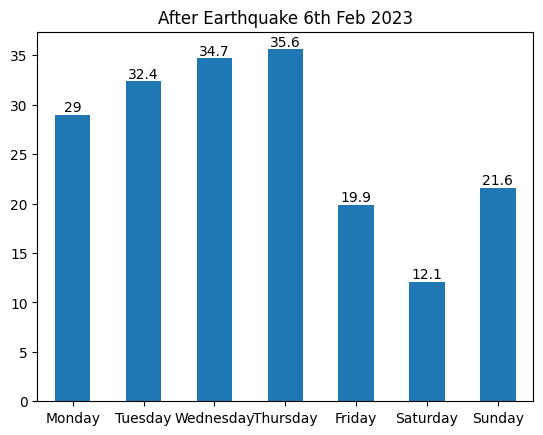

In [56]:
# day_df_after = round(pd.DataFrame(video_df_after['pushblishDayName'].value_counts())/int(divide_after),1)
# weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# day_df_after = day_df_after.reindex(weekdays)
ax = avg_daily_video_after.plot.bar(x='pushblishDayName', y='daily_counts', rot=0, xlabel="")
ax.bar_label(ax.containers[0], label_type='edge')
ax.set(title='After Earthquake 6th Feb 2023')
ax.get_legend().remove()
plt.show()

In [ ]:
# day_df = round(pd.DataFrame(video_df['pushblishDayName'].value_counts())/(52*len(years)),1)
# weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# day_df = day_df.reindex(weekdays)
# ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0, xlabel="")
# ax.bar_label(ax.containers[0], label_type='edge')
# ax.get_legend().remove()
# plt.show()

#### Monthly Upload After

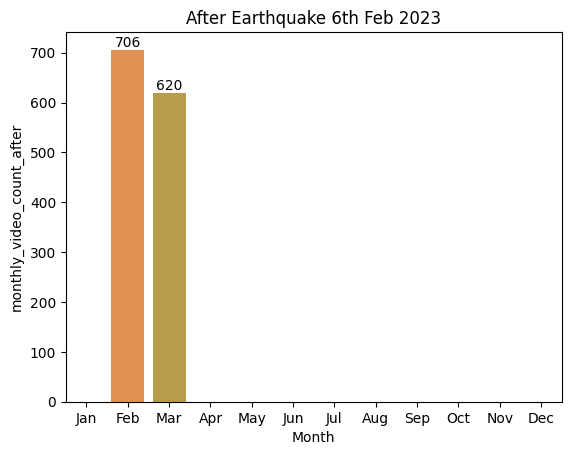

In [57]:
ax2_1 = sns.barplot(x='Month', y='monthly_video_count_after', data=video_after_per_month, order=sort_order)
ax2_1.bar_label(ax2_1.containers[0], label_type='edge')
ax2_1.set(title='After Earthquake 6th Feb 2023')
plt.show()

In [ ]:
# video_before_per_month = video_df_before.groupby('Month', as_index =False).size()
# sort_order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',]
# video_before_per_month.index = pd.CategoricalIndex(video_before_per_month['Month'], categories = sort_order, ordered= True)
# video_before_per_month.sort_index()

In [ ]:
# ax2_2 = sns.barplot(x='Month', y='size', data=video_before_per_month, order=Months_Order)
# ax2_2.bar_label(ax2_2.containers[0], label_type='edge')
# ax2_2.set(title='Before Earthquake 6th Feb 2023')
# plt.show()